In [37]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,t2m_volatility_3d_lag3,t2m_anomaly_lag1,t2m_anomaly_lag2,t2m_anomaly_lag3,temp_gradient_surface_lag1,temp_gradient_surface_lag2,temp_gradient_surface_lag3,wind_chill_factor_lag1,wind_chill_factor_lag2,wind_chill_factor_lag3
16364,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,0.018506,1.599108,0.979108,0.219108,-0.38,-0.18,-0.26,27.609,27.039,26.639
16365,2025-11-11,27.18,26.98,26.62,26.53,27.73,30.78,25.67,27.92,30.65,...,0.019798,1.779108,1.599108,0.979108,-0.21,-0.38,-0.18,27.944,27.609,27.039
16366,2025-11-12,27.33,27.01,26.71,26.56,28.32,31.13,25.87,28.64,31.10,...,0.025492,1.549108,1.779108,1.599108,-0.17,-0.21,-0.38,27.671,27.944,27.609
16367,2025-11-13,26.98,27.10,26.82,26.59,27.32,29.18,25.70,27.44,29.09,...,0.015188,2.139108,1.549108,1.779108,-0.07,-0.17,-0.21,28.244,27.671,27.944
16368,2025-11-14,25.64,26.43,26.78,26.63,25.75,28.15,23.67,25.84,28.22,...,0.004348,1.139108,2.139108,1.549108,-0.17,-0.07,-0.17,27.398,28.244,27.671


In [38]:
len(df.columns)

399

### X, y and Train / Test for Time Series

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

In [40]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [41]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 391
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [42]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [43]:
test_ratio = 0.1
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (14732, 391) (14732, 7)
Test  size: (1637, 391) (1637, 7)


### Train LightGBM (Multi-Output)

In [44]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance

In [45]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

# ดึง feature importance
importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# เลือก top-k features
TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

Selected top 200 features from LightGBM importance:
['month_progress', 'gwettop_roll7_std', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 't2m_trend_strength', 'tsoil3_roll7_std', 'ts_max_roll7_std', 'rhoa_roll3_std', 'to3_lag7', 'to3', 'tsoil4_lag7', 'ts_min_roll7_std', 'gwettop_roll3_std', 'doy_cos', 't2mwet_roll7_std', 'v2m_roll7_std', 'tsoil4_roll3_std', 'rhoa_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 't2m_max_roll7_std', 'tsoil4', 't10m_min_roll7_std', 't10m_max_roll7_std', 't2m_min_roll7_std', 'tsoil3_lag7', 'to3_lag1', 'v50m_roll7_std', 'gwetroot_roll7_std', 'to3_lag6', 'gwetprof_roll3_std', 'to3_lag2', 'ts_min_roll3_std', 'to3_lag4', 'temp_gradient_surface', 'temp_gradient_altitude', 't2m_anomaly', 't2m_rolling_iqr', 'gwetroot_roll3_std', 't10m_roll7_std', 'tsoil3_roll3_std', 'tsoil3', 'to3_lag5', 'tsoil2_roll7_std', 't2m_anomaly_lag2', 't2m_volatility_3d_lag2', 'temp_gradient_surface_lag3', 'soil_temp_moisture', 't2m_anomaly_lag3', 'ts_max_roll7_mean', 'ts_max_roll3_std', 'v

In [46]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train_fs) * (1 - val_ratio))

X_train_opt = X_train_fs.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train_fs.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape,   Y_val_opt.shape)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'objective': 'regression',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # suppress warnings
    }
    
    # Create model
    base_lgbm = LGBMRegressor(**params)
    model = MultiOutputRegressor(base_lgbm)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='lgbm_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=5400,  # timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

[I 2025-11-25 04:07:30,291] A new study created in memory with name: lgbm_t2m_forecast


Optuna train size: (11785, 200) (11785, 7)
Optuna val   size: (2947, 200) (2947, 7)


Best trial: 0. Best value: 1.18301:   1%|          | 1/100 [00:24<41:02, 24.87s/it, 24.87/5400 seconds]

[I 2025-11-25 04:07:55,165] Trial 0 finished with value: 1.1830066067170424 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'num_leaves': 128, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_samples': 62}. Best is trial 0 with value: 1.1830066067170424.


Best trial: 1. Best value: 1.11392:   2%|▏         | 2/100 [01:28<1:17:44, 47.60s/it, 88.37/5400 seconds]

[I 2025-11-25 04:08:58,668] Trial 1 finished with value: 1.1139242153099413 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'max_depth': 15, 'num_leaves': 170, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'min_child_samples': 55}. Best is trial 1 with value: 1.1139242153099413.


Best trial: 2. Best value: 1.11247:   3%|▎         | 3/100 [01:53<1:00:23, 37.36s/it, 113.55/5400 seconds]

[I 2025-11-25 04:09:23,842] Trial 2 finished with value: 1.112467995855907 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'reg_alpha': 0.00012724181576752517, 'reg_lambda': 0.1165691561324743, 'min_child_samples': 24}. Best is trial 2 with value: 1.112467995855907.


Best trial: 2. Best value: 1.11247:   4%|▍         | 4/100 [01:59<40:00, 25.00s/it, 119.61/5400 seconds]  

[I 2025-11-25 04:09:29,902] Trial 3 finished with value: 1.114734799712423 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'num_leaves': 129, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_alpha': 3.4671276804481113, 'reg_lambda': 4.905556676028774, 'min_child_samples': 82}. Best is trial 2 with value: 1.112467995855907.


Best trial: 4. Best value: 1.10954:   5%|▌         | 5/100 [02:40<48:27, 30.61s/it, 160.16/5400 seconds]

[I 2025-11-25 04:10:10,452] Trial 4 finished with value: 1.1095408814965153 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 11, 'num_leaves': 99, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'reg_alpha': 2.039373116525212e-08, 'reg_lambda': 1.527156759251193, 'min_child_samples': 29}. Best is trial 4 with value: 1.1095408814965153.


Best trial: 4. Best value: 1.10954:   6%|▌         | 6/100 [03:11<48:31, 30.97s/it, 191.83/5400 seconds]

[I 2025-11-25 04:10:42,121] Trial 5 finished with value: 1.1209556378667966 and parameters: {'n_estimators': 696, 'learning_rate': 0.028869220380495747, 'max_depth': 9, 'num_leaves': 118, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 0.09466630153726856, 'reg_lambda': 2.854239907497756, 'min_child_samples': 90}. Best is trial 4 with value: 1.1095408814965153.


Best trial: 4. Best value: 1.10954:   7%|▋         | 7/100 [03:21<37:17, 24.06s/it, 201.66/5400 seconds]

[I 2025-11-25 04:10:51,957] Trial 6 finished with value: 1.1723248808072142 and parameters: {'n_estimators': 638, 'learning_rate': 0.22999586428143728, 'max_depth': 4, 'num_leaves': 55, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'reg_alpha': 3.148441347423712e-05, 'reg_lambda': 2.7678419414850017e-06, 'min_child_samples': 84}. Best is trial 4 with value: 1.1095408814965153.


Best trial: 7. Best value: 1.10783:   8%|▊         | 8/100 [03:42<35:22, 23.07s/it, 222.63/5400 seconds]

[I 2025-11-25 04:11:12,923] Trial 7 finished with value: 1.1078285424258976 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_samples': 24}. Best is trial 7 with value: 1.1078285424258976.


Best trial: 7. Best value: 1.10783:   9%|▉         | 9/100 [03:51<28:04, 18.52s/it, 231.12/5400 seconds]

[I 2025-11-25 04:11:21,412] Trial 8 finished with value: 1.1386296483297174 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'num_leaves': 151, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07, 'min_child_samples': 87}. Best is trial 7 with value: 1.1078285424258976.


Best trial: 9. Best value: 1.10593:  10%|█         | 10/100 [04:02<24:26, 16.29s/it, 242.43/5400 seconds]

[I 2025-11-25 04:11:32,724] Trial 9 finished with value: 1.1059323787560964 and parameters: {'n_estimators': 661, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'num_leaves': 76, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_alpha': 0.005470376807480391, 'reg_lambda': 0.9658611176861268, 'min_child_samples': 50}. Best is trial 9 with value: 1.1059323787560964.


Best trial: 9. Best value: 1.10593:  11%|█         | 11/100 [04:37<32:49, 22.13s/it, 277.79/5400 seconds]

[I 2025-11-25 04:12:08,083] Trial 10 finished with value: 1.137332658185834 and parameters: {'n_estimators': 962, 'learning_rate': 0.07457153485515941, 'max_depth': 6, 'num_leaves': 82, 'subsample': 0.8010124870699186, 'colsample_bytree': 0.9407901565064135, 'reg_alpha': 0.00775155271689379, 'reg_lambda': 0.0037022205646195516, 'min_child_samples': 40}. Best is trial 9 with value: 1.1059323787560964.


Best trial: 11. Best value: 1.10503:  12%|█▏        | 12/100 [04:47<27:02, 18.44s/it, 287.80/5400 seconds]

[I 2025-11-25 04:12:18,098] Trial 11 finished with value: 1.1050275858843102 and parameters: {'n_estimators': 282, 'learning_rate': 0.0319033384233669, 'max_depth': 7, 'num_leaves': 23, 'subsample': 0.9962928066797128, 'colsample_bytree': 0.8920339412764792, 'reg_alpha': 3.925336430734594, 'reg_lambda': 0.012031643452401406, 'min_child_samples': 7}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 11. Best value: 1.10503:  13%|█▎        | 13/100 [04:54<21:31, 14.84s/it, 294.35/5400 seconds]

[I 2025-11-25 04:12:24,646] Trial 12 finished with value: 1.1073493596374544 and parameters: {'n_estimators': 191, 'learning_rate': 0.041359993857237216, 'max_depth': 6, 'num_leaves': 21, 'subsample': 0.9978889042870341, 'colsample_bytree': 0.8886964891340507, 'reg_alpha': 0.020439174832648923, 'reg_lambda': 0.0025058322638851593, 'min_child_samples': 5}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 11. Best value: 1.10503:  14%|█▍        | 14/100 [05:44<36:35, 25.52s/it, 344.57/5400 seconds]

[I 2025-11-25 04:13:14,859] Trial 13 finished with value: 1.1179758700232065 and parameters: {'n_estimators': 860, 'learning_rate': 0.017901479162809, 'max_depth': 7, 'num_leaves': 200, 'subsample': 0.7766490421270442, 'colsample_bytree': 0.8639488533247444, 'reg_alpha': 0.3897043082453401, 'reg_lambda': 0.01226910180312559, 'min_child_samples': 8}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 11. Best value: 1.10503:  15%|█▌        | 15/100 [05:49<27:22, 19.32s/it, 349.51/5400 seconds]

[I 2025-11-25 04:13:19,800] Trial 14 finished with value: 1.10655624058955 and parameters: {'n_estimators': 302, 'learning_rate': 0.048376681000447334, 'max_depth': 4, 'num_leaves': 79, 'subsample': 0.8002737397145369, 'colsample_bytree': 0.8634948389421102, 'reg_alpha': 0.0012909685684868433, 'reg_lambda': 0.00011596219477212376, 'min_child_samples': 69}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 11. Best value: 1.10503:  16%|█▌        | 16/100 [05:56<21:51, 15.62s/it, 356.52/5400 seconds]

[I 2025-11-25 04:13:26,818] Trial 15 finished with value: 1.121373444439224 and parameters: {'n_estimators': 243, 'learning_rate': 0.10168597339925738, 'max_depth': 8, 'num_leaves': 21, 'subsample': 0.8561711433906496, 'colsample_bytree': 0.9319634657809465, 'reg_alpha': 0.5839099780425707, 'reg_lambda': 0.0001346855749046717, 'min_child_samples': 44}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 11. Best value: 1.10503:  17%|█▋        | 17/100 [06:10<21:05, 15.25s/it, 370.91/5400 seconds]

[I 2025-11-25 04:13:41,202] Trial 16 finished with value: 1.1182423552164527 and parameters: {'n_estimators': 805, 'learning_rate': 0.03591872716986905, 'max_depth': 5, 'num_leaves': 61, 'subsample': 0.7311941285873849, 'colsample_bytree': 0.8064114554738081, 'reg_alpha': 0.0023272354343269164, 'reg_lambda': 0.06544028290140903, 'min_child_samples': 38}. Best is trial 11 with value: 1.1050275858843102.


Best trial: 17. Best value: 1.10174:  18%|█▊        | 18/100 [06:17<17:27, 12.78s/it, 377.94/5400 seconds]

[I 2025-11-25 04:13:48,237] Trial 17 finished with value: 1.101736499077066 and parameters: {'n_estimators': 589, 'learning_rate': 0.018823978814157837, 'max_depth': 3, 'num_leaves': 86, 'subsample': 0.8597523289555756, 'colsample_bytree': 0.9989207699958154, 'reg_alpha': 3.199160813819233e-06, 'reg_lambda': 0.0014561469589187425, 'min_child_samples': 100}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  19%|█▉        | 19/100 [06:34<18:52, 13.98s/it, 394.72/5400 seconds]

[I 2025-11-25 04:14:05,011] Trial 18 finished with value: 1.1102962993143715 and parameters: {'n_estimators': 504, 'learning_rate': 0.01932292459014695, 'max_depth': 7, 'num_leaves': 100, 'subsample': 0.9876507096332325, 'colsample_bytree': 0.9886343731588046, 'reg_alpha': 1.2896361738722175e-06, 'reg_lambda': 0.0008882425176175858, 'min_child_samples': 98}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  20%|██        | 20/100 [07:09<27:09, 20.37s/it, 429.99/5400 seconds]

[I 2025-11-25 04:14:40,286] Trial 19 finished with value: 1.1098623393561975 and parameters: {'n_estimators': 335, 'learning_rate': 0.010425658055299656, 'max_depth': 14, 'num_leaves': 149, 'subsample': 0.939872082071249, 'colsample_bytree': 0.944720945336574, 'reg_alpha': 2.1014145223570988e-06, 'reg_lambda': 1.9247403548396374e-05, 'min_child_samples': 76}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  21%|██        | 21/100 [07:24<24:27, 18.57s/it, 444.36/5400 seconds]

[I 2025-11-25 04:14:54,657] Trial 20 finished with value: 1.1089303131317745 and parameters: {'n_estimators': 543, 'learning_rate': 0.019008649362052606, 'max_depth': 5, 'num_leaves': 34, 'subsample': 0.8651250666290946, 'colsample_bytree': 0.8128534859431064, 'reg_alpha': 1.7739013117825787e-07, 'reg_lambda': 1.2722974438529106e-08, 'min_child_samples': 15}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  22%|██▏       | 22/100 [07:33<20:30, 15.78s/it, 453.62/5400 seconds]

[I 2025-11-25 04:15:03,916] Trial 21 finished with value: 1.1070572639277498 and parameters: {'n_estimators': 667, 'learning_rate': 0.03376615172791703, 'max_depth': 3, 'num_leaves': 74, 'subsample': 0.8528005797652903, 'colsample_bytree': 0.9056578303691861, 'reg_alpha': 0.0003486811621842339, 'reg_lambda': 0.015752775785687467, 'min_child_samples': 50}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  23%|██▎       | 23/100 [07:41<17:10, 13.38s/it, 461.40/5400 seconds]

[I 2025-11-25 04:15:11,697] Trial 22 finished with value: 1.1129362246195131 and parameters: {'n_estimators': 625, 'learning_rate': 0.055132819024251246, 'max_depth': 3, 'num_leaves': 91, 'subsample': 0.7581748095340151, 'colsample_bytree': 0.8481624245936998, 'reg_alpha': 7.104228167938738e-06, 'reg_lambda': 0.5522252710468681, 'min_child_samples': 69}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  24%|██▍       | 24/100 [08:05<21:04, 16.64s/it, 485.66/5400 seconds]

[I 2025-11-25 04:15:35,953] Trial 23 finished with value: 1.1145141334349402 and parameters: {'n_estimators': 806, 'learning_rate': 0.02223984073327138, 'max_depth': 5, 'num_leaves': 69, 'subsample': 0.9581107629016726, 'colsample_bytree': 0.9994120101491236, 'reg_alpha': 0.033608872821702634, 'reg_lambda': 0.00033714761656287686, 'min_child_samples': 32}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  25%|██▌       | 25/100 [08:17<19:01, 15.22s/it, 497.55/5400 seconds]

[I 2025-11-25 04:15:47,848] Trial 24 finished with value: 1.102253011813646 and parameters: {'n_estimators': 581, 'learning_rate': 0.015051638978392508, 'max_depth': 4, 'num_leaves': 112, 'subsample': 0.8264392134038689, 'colsample_bytree': 0.9649750017972418, 'reg_alpha': 0.8919679547618734, 'reg_lambda': 0.02009528396258976, 'min_child_samples': 99}. Best is trial 17 with value: 1.101736499077066.


Best trial: 17. Best value: 1.10174:  26%|██▌       | 26/100 [08:43<22:50, 18.52s/it, 523.78/5400 seconds]

[I 2025-11-25 04:16:14,077] Trial 25 finished with value: 1.10956466213618 and parameters: {'n_estimators': 583, 'learning_rate': 0.014299925001055883, 'max_depth': 7, 'num_leaves': 113, 'subsample': 0.8876612366206835, 'colsample_bytree': 0.954471739782476, 'reg_alpha': 0.8077922906878874, 'reg_lambda': 0.0244111663192159, 'min_child_samples': 100}. Best is trial 17 with value: 1.101736499077066.


Best trial: 26. Best value: 1.10143:  27%|██▋       | 27/100 [08:53<19:20, 15.89s/it, 533.55/5400 seconds]

[I 2025-11-25 04:16:23,840] Trial 26 finished with value: 1.1014308787681417 and parameters: {'n_estimators': 447, 'learning_rate': 0.013773700532225581, 'max_depth': 4, 'num_leaves': 147, 'subsample': 0.8224928772618226, 'colsample_bytree': 0.9675307370657791, 'reg_alpha': 1.9663489178866635, 'reg_lambda': 0.004789253118409875, 'min_child_samples': 93}. Best is trial 26 with value: 1.1014308787681417.


Best trial: 27. Best value: 1.10108:  28%|██▊       | 28/100 [09:06<18:06, 15.09s/it, 546.75/5400 seconds]

[I 2025-11-25 04:16:37,039] Trial 27 finished with value: 1.101084742376284 and parameters: {'n_estimators': 479, 'learning_rate': 0.014103418862184924, 'max_depth': 4, 'num_leaves': 145, 'subsample': 0.8335105181886684, 'colsample_bytree': 0.9662523052494798, 'reg_alpha': 0.12422357563584471, 'reg_lambda': 0.001977991435865471, 'min_child_samples': 93}. Best is trial 27 with value: 1.101084742376284.


Best trial: 27. Best value: 1.10108:  29%|██▉       | 29/100 [09:24<18:49, 15.91s/it, 564.58/5400 seconds]

[I 2025-11-25 04:16:54,868] Trial 28 finished with value: 1.1061688980648217 and parameters: {'n_estimators': 452, 'learning_rate': 0.012708211149332566, 'max_depth': 5, 'num_leaves': 174, 'subsample': 0.82884525790717, 'colsample_bytree': 0.922576960942785, 'reg_alpha': 0.12614634054253632, 'reg_lambda': 4.0015668451015035e-05, 'min_child_samples': 92}. Best is trial 27 with value: 1.101084742376284.


Best trial: 27. Best value: 1.10108:  30%|███       | 30/100 [09:35<16:44, 14.35s/it, 575.31/5400 seconds]

[I 2025-11-25 04:17:05,599] Trial 29 finished with value: 1.1014723599546565 and parameters: {'n_estimators': 405, 'learning_rate': 0.01038272773459015, 'max_depth': 4, 'num_leaves': 137, 'subsample': 0.883231109342479, 'colsample_bytree': 0.9698410138458495, 'reg_alpha': 1.3402913466027176e-07, 'reg_lambda': 0.001287308930136732, 'min_child_samples': 77}. Best is trial 27 with value: 1.101084742376284.


Best trial: 27. Best value: 1.10108:  31%|███       | 31/100 [09:56<18:44, 16.29s/it, 596.11/5400 seconds]

[I 2025-11-25 04:17:26,406] Trial 30 finished with value: 1.1060104819753815 and parameters: {'n_estimators': 403, 'learning_rate': 0.011704303023394341, 'max_depth': 6, 'num_leaves': 137, 'subsample': 0.8251867852889606, 'colsample_bytree': 0.9696540628217762, 'reg_alpha': 1.2822835644335808e-07, 'reg_lambda': 0.00035140129341215546, 'min_child_samples': 77}. Best is trial 27 with value: 1.101084742376284.


Best trial: 31. Best value: 1.10102:  32%|███▏      | 32/100 [10:06<16:26, 14.51s/it, 606.48/5400 seconds]

[I 2025-11-25 04:17:36,772] Trial 31 finished with value: 1.1010160881576716 and parameters: {'n_estimators': 464, 'learning_rate': 0.015615361451828395, 'max_depth': 4, 'num_leaves': 158, 'subsample': 0.878219389989171, 'colsample_bytree': 0.9721473348243497, 'reg_alpha': 1.196441216457519e-08, 'reg_lambda': 0.0029075331912124087, 'min_child_samples': 93}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  33%|███▎      | 33/100 [10:17<14:55, 13.36s/it, 617.15/5400 seconds]

[I 2025-11-25 04:17:47,440] Trial 32 finished with value: 1.101858480327863 and parameters: {'n_estimators': 468, 'learning_rate': 0.015818624055066923, 'max_depth': 4, 'num_leaves': 166, 'subsample': 0.8912029960237364, 'colsample_bytree': 0.9638231862117747, 'reg_alpha': 1.3988079666240775e-08, 'reg_lambda': 0.0023270823841944053, 'min_child_samples': 62}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  34%|███▍      | 34/100 [10:27<13:32, 12.31s/it, 627.00/5400 seconds]

[I 2025-11-25 04:17:57,292] Trial 33 finished with value: 1.1021954831134133 and parameters: {'n_estimators': 388, 'learning_rate': 0.010052277606420287, 'max_depth': 4, 'num_leaves': 152, 'subsample': 0.8863027697431409, 'colsample_bytree': 0.9190292603436169, 'reg_alpha': 7.648778059264068e-08, 'reg_lambda': 0.2574057020585128, 'min_child_samples': 93}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  35%|███▌      | 35/100 [10:40<13:44, 12.68s/it, 640.56/5400 seconds]

[I 2025-11-25 04:18:10,857] Trial 34 finished with value: 1.1088034511132099 and parameters: {'n_estimators': 521, 'learning_rate': 0.023259274397810222, 'max_depth': 5, 'num_leaves': 188, 'subsample': 0.7650723155381586, 'colsample_bytree': 0.9728984059205477, 'reg_alpha': 5.37354102174604e-07, 'reg_lambda': 0.00409142454317279, 'min_child_samples': 81}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  36%|███▌      | 36/100 [10:54<13:57, 13.08s/it, 654.56/5400 seconds]

[I 2025-11-25 04:18:24,857] Trial 35 finished with value: 1.1043471526286515 and parameters: {'n_estimators': 329, 'learning_rate': 0.012407964702088648, 'max_depth': 6, 'num_leaves': 137, 'subsample': 0.836084108577357, 'colsample_bytree': 0.7124756259501557, 'reg_alpha': 5.59976429870279e-08, 'reg_lambda': 3.1047208770819326e-06, 'min_child_samples': 72}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  37%|███▋      | 37/100 [11:18<17:06, 16.29s/it, 678.34/5400 seconds]

[I 2025-11-25 04:18:48,632] Trial 36 finished with value: 1.1076087796341956 and parameters: {'n_estimators': 457, 'learning_rate': 0.01597435187813284, 'max_depth': 8, 'num_leaves': 165, 'subsample': 0.791745297513698, 'colsample_bytree': 0.948213085012635, 'reg_alpha': 1.0925032175320863e-08, 'reg_lambda': 0.00043745500035396914, 'min_child_samples': 93}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 31. Best value: 1.10102:  38%|███▊      | 38/100 [11:23<13:29, 13.06s/it, 683.86/5400 seconds]

[I 2025-11-25 04:18:54,150] Trial 37 finished with value: 1.1236524406637778 and parameters: {'n_estimators': 233, 'learning_rate': 0.010042013934902182, 'max_depth': 4, 'num_leaves': 127, 'subsample': 0.951874042876385, 'colsample_bytree': 0.7677410569512203, 'reg_alpha': 0.00016687654118716943, 'reg_lambda': 1.8493467449504076e-05, 'min_child_samples': 60}. Best is trial 31 with value: 1.1010160881576716.


Best trial: 38. Best value: 1.10087:  39%|███▉      | 39/100 [11:29<10:55, 10.75s/it, 689.21/5400 seconds]

[I 2025-11-25 04:18:59,506] Trial 38 finished with value: 1.1008739932328815 and parameters: {'n_estimators': 349, 'learning_rate': 0.024024194163926805, 'max_depth': 3, 'num_leaves': 142, 'subsample': 0.9101646170588582, 'colsample_bytree': 0.9112922950216079, 'reg_alpha': 3.3593816161576603e-07, 'reg_lambda': 0.007012359779913582, 'min_child_samples': 87}. Best is trial 38 with value: 1.1008739932328815.


Best trial: 38. Best value: 1.10087:  40%|████      | 40/100 [11:34<09:00,  9.01s/it, 694.18/5400 seconds]

[I 2025-11-25 04:19:04,470] Trial 39 finished with value: 1.1010451649011868 and parameters: {'n_estimators': 369, 'learning_rate': 0.024932845495376946, 'max_depth': 3, 'num_leaves': 175, 'subsample': 0.9200197287674735, 'colsample_bytree': 0.8355560148961885, 'reg_alpha': 1.8504702437150475, 'reg_lambda': 0.05709411112822597, 'min_child_samples': 87}. Best is trial 38 with value: 1.1008739932328815.


Best trial: 38. Best value: 1.10087:  41%|████      | 41/100 [11:37<07:06,  7.23s/it, 697.26/5400 seconds]

[I 2025-11-25 04:19:07,549] Trial 40 finished with value: 1.1081197678283528 and parameters: {'n_estimators': 156, 'learning_rate': 0.022728066309798074, 'max_depth': 3, 'num_leaves': 180, 'subsample': 0.9205766405416196, 'colsample_bytree': 0.8491140563564833, 'reg_alpha': 0.09022599847448898, 'reg_lambda': 0.05863619919360671, 'min_child_samples': 85}. Best is trial 38 with value: 1.1008739932328815.


Best trial: 41. Best value: 1.10082:  42%|████▏     | 42/100 [11:43<06:33,  6.79s/it, 703.01/5400 seconds]

[I 2025-11-25 04:19:13,301] Trial 41 finished with value: 1.1008247441222514 and parameters: {'n_estimators': 365, 'learning_rate': 0.02676178259372094, 'max_depth': 3, 'num_leaves': 159, 'subsample': 0.9139960401805057, 'colsample_bytree': 0.9179694433306845, 'reg_alpha': 9.42495592291872, 'reg_lambda': 0.17836677761355915, 'min_child_samples': 90}. Best is trial 41 with value: 1.1008247441222514.


Best trial: 41. Best value: 1.10082:  43%|████▎     | 43/100 [11:48<05:56,  6.25s/it, 708.01/5400 seconds]

[I 2025-11-25 04:19:18,301] Trial 42 finished with value: 1.101859606578188 and parameters: {'n_estimators': 361, 'learning_rate': 0.026451078169433012, 'max_depth': 3, 'num_leaves': 162, 'subsample': 0.9161156067497386, 'colsample_bytree': 0.8241145511968017, 'reg_alpha': 5.904076351773133, 'reg_lambda': 0.16847631472238128, 'min_child_samples': 87}. Best is trial 41 with value: 1.1008247441222514.


Best trial: 41. Best value: 1.10082:  44%|████▍     | 44/100 [11:52<05:19,  5.71s/it, 712.44/5400 seconds]

[I 2025-11-25 04:19:22,731] Trial 43 finished with value: 1.1015306518392067 and parameters: {'n_estimators': 271, 'learning_rate': 0.04365076932194567, 'max_depth': 3, 'num_leaves': 158, 'subsample': 0.9723592120481569, 'colsample_bytree': 0.9064671701056606, 'reg_alpha': 9.46948315766657, 'reg_lambda': 2.221284593273244, 'min_child_samples': 81}. Best is trial 41 with value: 1.1008247441222514.


Best trial: 44. Best value: 1.10075:  45%|████▌     | 45/100 [11:57<05:00,  5.47s/it, 717.35/5400 seconds]

[I 2025-11-25 04:19:27,648] Trial 44 finished with value: 1.1007465467865238 and parameters: {'n_estimators': 352, 'learning_rate': 0.02195232467928882, 'max_depth': 3, 'num_leaves': 189, 'subsample': 0.9388427729595352, 'colsample_bytree': 0.87640988839631, 'reg_alpha': 1.766218517956879, 'reg_lambda': 0.39940451292667334, 'min_child_samples': 89}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  46%|████▌     | 46/100 [12:18<09:04, 10.08s/it, 738.18/5400 seconds]

[I 2025-11-25 04:19:48,471] Trial 45 finished with value: 1.1282280761045094 and parameters: {'n_estimators': 354, 'learning_rate': 0.05972538233296227, 'max_depth': 12, 'num_leaves': 193, 'subsample': 0.9044718143160811, 'colsample_bytree': 0.8700943088582156, 'reg_alpha': 1.7940366937698855, 'reg_lambda': 6.555398784549567, 'min_child_samples': 88}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  47%|████▋     | 47/100 [12:22<07:18,  8.28s/it, 742.26/5400 seconds]

[I 2025-11-25 04:19:52,553] Trial 46 finished with value: 1.1009675339161096 and parameters: {'n_estimators': 299, 'learning_rate': 0.02705199441654183, 'max_depth': 3, 'num_leaves': 175, 'subsample': 0.9331403589495627, 'colsample_bytree': 0.78170815987825, 'reg_alpha': 2.6083242713459058e-08, 'reg_lambda': 0.40940343736114476, 'min_child_samples': 83}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  48%|████▊     | 48/100 [12:40<09:51, 11.38s/it, 760.89/5400 seconds]

[I 2025-11-25 04:20:11,186] Trial 47 finished with value: 1.1098812814596422 and parameters: {'n_estimators': 173, 'learning_rate': 0.0206524073783114, 'max_depth': 15, 'num_leaves': 183, 'subsample': 0.9471598580487954, 'colsample_bytree': 0.7660822645523062, 'reg_alpha': 2.603101046650298e-08, 'reg_lambda': 0.6535196188640948, 'min_child_samples': 81}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  49%|████▉     | 49/100 [12:44<07:44,  9.11s/it, 764.69/5400 seconds]

[I 2025-11-25 04:20:14,985] Trial 48 finished with value: 1.1017120937243958 and parameters: {'n_estimators': 234, 'learning_rate': 0.031057521212923017, 'max_depth': 3, 'num_leaves': 200, 'subsample': 0.9304401505579143, 'colsample_bytree': 0.7791151575973565, 'reg_alpha': 5.264952637387383e-07, 'reg_lambda': 0.40801130964212545, 'min_child_samples': 96}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  50%|█████     | 50/100 [12:52<07:09,  8.59s/it, 772.06/5400 seconds]

[I 2025-11-25 04:20:22,358] Trial 49 finished with value: 1.1092253822191853 and parameters: {'n_estimators': 310, 'learning_rate': 0.03631297584856426, 'max_depth': 5, 'num_leaves': 125, 'subsample': 0.9682965300152725, 'colsample_bytree': 0.6923545999675519, 'reg_alpha': 3.586528837941722e-08, 'reg_lambda': 1.9498976910736279, 'min_child_samples': 73}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  51%|█████     | 51/100 [12:55<05:42,  6.99s/it, 775.34/5400 seconds]

[I 2025-11-25 04:20:25,634] Trial 50 finished with value: 1.166787072891677 and parameters: {'n_estimators': 102, 'learning_rate': 0.017404205051111715, 'max_depth': 3, 'num_leaves': 169, 'subsample': 0.9768974348415611, 'colsample_bytree': 0.8797313927664524, 'reg_alpha': 6.186220763908092e-05, 'reg_lambda': 9.23391146648784, 'min_child_samples': 62}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  52%|█████▏    | 52/100 [13:02<05:42,  7.13s/it, 782.77/5400 seconds]

[I 2025-11-25 04:20:33,064] Trial 51 finished with value: 1.10126423123403 and parameters: {'n_estimators': 422, 'learning_rate': 0.02575874358642038, 'max_depth': 3, 'num_leaves': 175, 'subsample': 0.9338668634750951, 'colsample_bytree': 0.8307468680060461, 'reg_alpha': 0.33045677597605366, 'reg_lambda': 0.0431574883521151, 'min_child_samples': 89}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  53%|█████▎    | 53/100 [13:10<05:47,  7.39s/it, 790.78/5400 seconds]

[I 2025-11-25 04:20:41,079] Trial 52 finished with value: 1.1029905301865335 and parameters: {'n_estimators': 371, 'learning_rate': 0.027391712546486948, 'max_depth': 4, 'num_leaves': 157, 'subsample': 0.9027023379447712, 'colsample_bytree': 0.7940459315014613, 'reg_alpha': 2.3051229896027525, 'reg_lambda': 0.15035690644881355, 'min_child_samples': 85}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  54%|█████▍    | 54/100 [13:15<05:01,  6.56s/it, 795.40/5400 seconds]

[I 2025-11-25 04:20:45,689] Trial 53 finished with value: 1.1021653649960899 and parameters: {'n_estimators': 271, 'learning_rate': 0.04045432727673382, 'max_depth': 3, 'num_leaves': 186, 'subsample': 0.8753793615144546, 'colsample_bytree': 0.8455321112015831, 'reg_alpha': 1.0491521356408594e-08, 'reg_lambda': 0.008707384893956411, 'min_child_samples': 96}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  55%|█████▌    | 55/100 [13:22<05:04,  6.76s/it, 802.63/5400 seconds]

[I 2025-11-25 04:20:52,921] Trial 54 finished with value: 1.1021933998015006 and parameters: {'n_estimators': 303, 'learning_rate': 0.023158997146641512, 'max_depth': 4, 'num_leaves': 177, 'subsample': 0.9253688733198427, 'colsample_bytree': 0.9048679736842785, 'reg_alpha': 2.290558672731073e-07, 'reg_lambda': 1.1451183844008372, 'min_child_samples': 83}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  56%|█████▌    | 56/100 [13:36<06:26,  8.79s/it, 816.16/5400 seconds]

[I 2025-11-25 04:21:06,457] Trial 55 finished with value: 1.1349291987286563 and parameters: {'n_estimators': 198, 'learning_rate': 0.10420459468878085, 'max_depth': 10, 'num_leaves': 193, 'subsample': 0.9026137148751713, 'colsample_bytree': 0.8821035766484606, 'reg_alpha': 4.048455469317907, 'reg_lambda': 0.04500395883006303, 'min_child_samples': 90}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  57%|█████▋    | 57/100 [13:42<05:48,  8.10s/it, 822.65/5400 seconds]

[I 2025-11-25 04:21:12,948] Trial 56 finished with value: 1.1017422045473997 and parameters: {'n_estimators': 377, 'learning_rate': 0.030078297129187966, 'max_depth': 3, 'num_leaves': 173, 'subsample': 0.9597874865217888, 'colsample_bytree': 0.9283449365491044, 'reg_alpha': 3.790473460454539e-08, 'reg_lambda': 0.11101078651781113, 'min_child_samples': 79}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  58%|█████▊    | 58/100 [13:52<06:02,  8.63s/it, 832.52/5400 seconds]

[I 2025-11-25 04:21:22,814] Trial 57 finished with value: 1.1046715188807539 and parameters: {'n_estimators': 335, 'learning_rate': 0.02084185709950088, 'max_depth': 5, 'num_leaves': 157, 'subsample': 0.6303002884706111, 'colsample_bytree': 0.6056470054581535, 'reg_alpha': 0.01523575942402541, 'reg_lambda': 0.007372797859484906, 'min_child_samples': 86}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  59%|█████▉    | 59/100 [14:09<07:40, 11.23s/it, 849.81/5400 seconds]

[I 2025-11-25 04:21:40,099] Trial 58 finished with value: 1.1761235769929088 and parameters: {'n_estimators': 522, 'learning_rate': 0.22857480686596335, 'max_depth': 6, 'num_leaves': 190, 'subsample': 0.9419626124035573, 'colsample_bytree': 0.8334460401004267, 'reg_alpha': 1.6427041163261046e-05, 'reg_lambda': 0.35328689212075615, 'min_child_samples': 96}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  60%|██████    | 60/100 [14:16<06:40, 10.00s/it, 856.95/5400 seconds]

[I 2025-11-25 04:21:47,247] Trial 59 finished with value: 1.1007589845075614 and parameters: {'n_estimators': 429, 'learning_rate': 0.016826765881858326, 'max_depth': 3, 'num_leaves': 142, 'subsample': 0.8698736100973132, 'colsample_bytree': 0.7326930674952481, 'reg_alpha': 0.27804689655289977, 'reg_lambda': 0.028635899678335353, 'min_child_samples': 67}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 44. Best value: 1.10075:  61%|██████    | 61/100 [15:04<13:47, 21.22s/it, 904.34/5400 seconds]

[I 2025-11-25 04:22:34,634] Trial 60 finished with value: 1.1129906577280797 and parameters: {'n_estimators': 492, 'learning_rate': 0.01670123529476456, 'max_depth': 13, 'num_leaves': 142, 'subsample': 0.8659723034728287, 'colsample_bytree': 0.7414173422647402, 'reg_alpha': 0.000830125373839143, 'reg_lambda': 4.27394979616864, 'min_child_samples': 66}. Best is trial 44 with value: 1.1007465467865238.


Best trial: 61. Best value: 1.10064:  62%|██████▏   | 62/100 [15:10<10:34, 16.70s/it, 910.48/5400 seconds]

[I 2025-11-25 04:22:40,778] Trial 61 finished with value: 1.1006397309371962 and parameters: {'n_estimators': 401, 'learning_rate': 0.025397792244655267, 'max_depth': 3, 'num_leaves': 161, 'subsample': 0.8452644852494107, 'colsample_bytree': 0.7245977122851267, 'reg_alpha': 0.29460867320096173, 'reg_lambda': 0.03188713072114804, 'min_child_samples': 89}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  63%|██████▎   | 63/100 [15:19<08:56, 14.51s/it, 919.88/5400 seconds]

[I 2025-11-25 04:22:50,172] Trial 62 finished with value: 1.1031098526557679 and parameters: {'n_estimators': 444, 'learning_rate': 0.01906508328682971, 'max_depth': 4, 'num_leaves': 120, 'subsample': 0.849614466292681, 'colsample_bytree': 0.7203198197125256, 'reg_alpha': 0.26991764356984527, 'reg_lambda': 0.02978297751817778, 'min_child_samples': 74}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  64%|██████▍   | 64/100 [15:26<07:13, 12.03s/it, 926.14/5400 seconds]

[I 2025-11-25 04:22:56,430] Trial 63 finished with value: 1.1034067330371768 and parameters: {'n_estimators': 417, 'learning_rate': 0.03527052615490978, 'max_depth': 3, 'num_leaves': 151, 'subsample': 0.874642849136858, 'colsample_bytree': 0.6821554660897542, 'reg_alpha': 0.0036035924668631762, 'reg_lambda': 5.772951868897447e-07, 'min_child_samples': 90}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  65%|██████▌   | 65/100 [15:43<07:54, 13.56s/it, 943.28/5400 seconds]

[I 2025-11-25 04:23:13,573] Trial 64 finished with value: 1.1124538082002855 and parameters: {'n_estimators': 997, 'learning_rate': 0.028430730932274162, 'max_depth': 4, 'num_leaves': 161, 'subsample': 0.6955973390152621, 'colsample_bytree': 0.7039267125730175, 'reg_alpha': 0.06466747119891585, 'reg_lambda': 0.0007650248533491442, 'min_child_samples': 83}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  66%|██████▌   | 66/100 [15:48<06:16, 11.08s/it, 948.56/5400 seconds]

[I 2025-11-25 04:23:18,855] Trial 65 finished with value: 1.1007704053746414 and parameters: {'n_estimators': 278, 'learning_rate': 0.021173432214954456, 'max_depth': 3, 'num_leaves': 133, 'subsample': 0.8979518789426485, 'colsample_bytree': 0.6479111408362144, 'reg_alpha': 0.8213701201380256, 'reg_lambda': 0.19799358829903121, 'min_child_samples': 68}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  67%|██████▋   | 67/100 [15:52<04:58,  9.04s/it, 952.85/5400 seconds]

[I 2025-11-25 04:23:23,148] Trial 66 finished with value: 1.1017098178638853 and parameters: {'n_estimators': 255, 'learning_rate': 0.02043773504076707, 'max_depth': 3, 'num_leaves': 141, 'subsample': 0.8442792345160443, 'colsample_bytree': 0.7489717479092449, 'reg_alpha': 1.1765131698856783, 'reg_lambda': 0.14186722408424374, 'min_child_samples': 54}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  68%|██████▊   | 68/100 [16:06<05:29, 10.29s/it, 966.05/5400 seconds]

[I 2025-11-25 04:23:36,348] Trial 67 finished with value: 1.1170941859254835 and parameters: {'n_estimators': 214, 'learning_rate': 0.04902754080582366, 'max_depth': 11, 'num_leaves': 105, 'subsample': 0.8939609894426914, 'colsample_bytree': 0.6534174515580327, 'reg_alpha': 0.2938338728913451, 'reg_lambda': 0.7456212039825535, 'min_child_samples': 69}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  69%|██████▉   | 69/100 [16:13<04:54,  9.50s/it, 973.72/5400 seconds]

[I 2025-11-25 04:23:44,015] Trial 68 finished with value: 1.1040961575485733 and parameters: {'n_estimators': 285, 'learning_rate': 0.02474158657821736, 'max_depth': 5, 'num_leaves': 135, 'subsample': 0.9068158120501794, 'colsample_bytree': 0.6496440136106254, 'reg_alpha': 0.5524388993064352, 'reg_lambda': 0.2758508924007654, 'min_child_samples': 57}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  70%|███████   | 70/100 [16:18<03:59,  7.99s/it, 978.18/5400 seconds]

[I 2025-11-25 04:23:48,476] Trial 69 finished with value: 1.101338807021312 and parameters: {'n_estimators': 322, 'learning_rate': 0.0312321573788443, 'max_depth': 3, 'num_leaves': 121, 'subsample': 0.8653015648147442, 'colsample_bytree': 0.6657178754340386, 'reg_alpha': 4.266281343028567, 'reg_lambda': 0.022158700111984425, 'min_child_samples': 78}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  71%|███████   | 71/100 [16:24<03:39,  7.58s/it, 984.81/5400 seconds]

[I 2025-11-25 04:23:55,100] Trial 70 finished with value: 1.1052428400016265 and parameters: {'n_estimators': 346, 'learning_rate': 0.03907210995356393, 'max_depth': 4, 'num_leaves': 153, 'subsample': 0.9862056398150546, 'colsample_bytree': 0.7428544234246482, 'reg_alpha': 0.04083156837195372, 'reg_lambda': 0.08636003737007127, 'min_child_samples': 44}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 61. Best value: 1.10064:  72%|███████▏  | 72/100 [16:33<03:43,  7.97s/it, 993.68/5400 seconds]

[I 2025-11-25 04:24:03,974] Trial 71 finished with value: 1.1019182391099847 and parameters: {'n_estimators': 414, 'learning_rate': 0.01772259732203283, 'max_depth': 4, 'num_leaves': 129, 'subsample': 0.8776595054806954, 'colsample_bytree': 0.7833290577259135, 'reg_alpha': 0.20064812821914876, 'reg_lambda': 0.013475435566640078, 'min_child_samples': 65}. Best is trial 61 with value: 1.1006397309371962.


Best trial: 72. Best value: 1.10057:  73%|███████▎  | 73/100 [16:39<03:16,  7.29s/it, 999.40/5400 seconds]

[I 2025-11-25 04:24:09,689] Trial 72 finished with value: 1.100565353173593 and parameters: {'n_estimators': 384, 'learning_rate': 0.02184012082451499, 'max_depth': 3, 'num_leaves': 169, 'subsample': 0.8950616930697846, 'colsample_bytree': 0.7278592800808361, 'reg_alpha': 9.876991116224094, 'reg_lambda': 0.22820216105603866, 'min_child_samples': 95}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  74%|███████▍  | 74/100 [16:44<02:55,  6.75s/it, 1004.87/5400 seconds]

[I 2025-11-25 04:24:15,167] Trial 73 finished with value: 1.101231993725099 and parameters: {'n_estimators': 394, 'learning_rate': 0.02194285587975109, 'max_depth': 3, 'num_leaves': 169, 'subsample': 0.9347874223470192, 'colsample_bytree': 0.7284206067583142, 'reg_alpha': 1.182649533971451, 'reg_lambda': 0.2241199346366595, 'min_child_samples': 96}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  75%|███████▌  | 75/100 [16:49<02:31,  6.07s/it, 1009.37/5400 seconds]

[I 2025-11-25 04:24:19,662] Trial 74 finished with value: 1.1006702251170204 and parameters: {'n_estimators': 290, 'learning_rate': 0.028210825532979194, 'max_depth': 3, 'num_leaves': 146, 'subsample': 0.9134985722339459, 'colsample_bytree': 0.7532539281450102, 'reg_alpha': 7.648265721766885, 'reg_lambda': 1.2230737842054755, 'min_child_samples': 91}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  76%|███████▌  | 76/100 [16:53<02:10,  5.43s/it, 1013.31/5400 seconds]

[I 2025-11-25 04:24:23,608] Trial 75 finished with value: 1.1182146817171033 and parameters: {'n_estimators': 139, 'learning_rate': 0.019023727519146525, 'max_depth': 4, 'num_leaves': 132, 'subsample': 0.8140091648742077, 'colsample_bytree': 0.7610432475330601, 'reg_alpha': 9.595126498731721, 'reg_lambda': 1.184797447318733, 'min_child_samples': 97}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  77%|███████▋  | 77/100 [17:07<03:02,  7.94s/it, 1027.09/5400 seconds]

[I 2025-11-25 04:24:37,387] Trial 76 finished with value: 1.1080756514970334 and parameters: {'n_estimators': 259, 'learning_rate': 0.023335004410825276, 'max_depth': 9, 'num_leaves': 144, 'subsample': 0.912174675567115, 'colsample_bytree': 0.7028319581160964, 'reg_alpha': 2.758741368466946, 'reg_lambda': 3.647402452829019, 'min_child_samples': 90}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  78%|███████▊  | 78/100 [17:12<02:39,  7.23s/it, 1032.67/5400 seconds]

[I 2025-11-25 04:24:42,961] Trial 77 finished with value: 1.101963691439885 and parameters: {'n_estimators': 433, 'learning_rate': 0.03318855545258258, 'max_depth': 3, 'num_leaves': 146, 'subsample': 0.8909587960137747, 'colsample_bytree': 0.6792335743401732, 'reg_alpha': 5.913539514794332, 'reg_lambda': 0.09160302246823283, 'min_child_samples': 49}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  79%|███████▉  | 79/100 [17:18<02:19,  6.67s/it, 1038.02/5400 seconds]

[I 2025-11-25 04:24:48,315] Trial 78 finished with value: 1.1034361248129123 and parameters: {'n_estimators': 347, 'learning_rate': 0.012703075362490024, 'max_depth': 3, 'num_leaves': 165, 'subsample': 0.8970785200760621, 'colsample_bytree': 0.7305410368610231, 'reg_alpha': 0.638860844988838, 'reg_lambda': 0.036416089652275864, 'min_child_samples': 92}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  80%|████████  | 80/100 [17:28<02:38,  7.95s/it, 1048.97/5400 seconds]

[I 2025-11-25 04:24:59,257] Trial 79 finished with value: 1.1057037527296119 and parameters: {'n_estimators': 393, 'learning_rate': 0.01442089784332298, 'max_depth': 5, 'num_leaves': 154, 'subsample': 0.8424725926272795, 'colsample_bytree': 0.7544675396927084, 'reg_alpha': 1.17499051580003, 'reg_lambda': 0.6883483079671107, 'min_child_samples': 79}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  81%|████████  | 81/100 [17:34<02:19,  7.35s/it, 1054.92/5400 seconds]

[I 2025-11-25 04:25:05,212] Trial 80 finished with value: 1.1035226901668374 and parameters: {'n_estimators': 293, 'learning_rate': 0.029028267634837724, 'max_depth': 4, 'num_leaves': 115, 'subsample': 0.9114849678581662, 'colsample_bytree': 0.6199696261087932, 'reg_alpha': 3.1109655104656007, 'reg_lambda': 0.005909876093910566, 'min_child_samples': 99}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  82%|████████▏ | 82/100 [17:39<01:59,  6.65s/it, 1059.92/5400 seconds]

[I 2025-11-25 04:25:10,219] Trial 81 finished with value: 1.100936788318711 and parameters: {'n_estimators': 317, 'learning_rate': 0.02682129065154321, 'max_depth': 3, 'num_leaves': 180, 'subsample': 0.9561996159188791, 'colsample_bytree': 0.7804093730742476, 'reg_alpha': 6.296630557006419, 'reg_lambda': 0.4271662210531617, 'min_child_samples': 84}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  83%|████████▎ | 83/100 [17:44<01:44,  6.17s/it, 1064.97/5400 seconds]

[I 2025-11-25 04:25:15,260] Trial 82 finished with value: 1.1008425694978654 and parameters: {'n_estimators': 329, 'learning_rate': 0.024363833707366993, 'max_depth': 3, 'num_leaves': 184, 'subsample': 0.9573009220356611, 'colsample_bytree': 0.805065947058518, 'reg_alpha': 8.311852437136992, 'reg_lambda': 1.9288057059204637, 'min_child_samples': 88}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  84%|████████▍ | 84/100 [17:50<01:36,  6.05s/it, 1070.75/5400 seconds]

[I 2025-11-25 04:25:21,043] Trial 83 finished with value: 1.1008958201934718 and parameters: {'n_estimators': 353, 'learning_rate': 0.02087946662177487, 'max_depth': 3, 'num_leaves': 140, 'subsample': 0.9454920141920462, 'colsample_bytree': 0.9118777263742914, 'reg_alpha': 5.457128587671392, 'reg_lambda': 2.0361351212322747, 'min_child_samples': 94}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  85%|████████▌ | 85/100 [17:58<01:38,  6.54s/it, 1078.45/5400 seconds]

[I 2025-11-25 04:25:28,738] Trial 84 finished with value: 1.1037747226805574 and parameters: {'n_estimators': 377, 'learning_rate': 0.024640633909481523, 'max_depth': 4, 'num_leaves': 148, 'subsample': 0.9245018520988144, 'colsample_bytree': 0.8156055586369658, 'reg_alpha': 9.856218143495436, 'reg_lambda': 1.3499514578803689, 'min_child_samples': 88}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  86%|████████▌ | 86/100 [18:02<01:20,  5.77s/it, 1082.40/5400 seconds]

[I 2025-11-25 04:25:32,693] Trial 85 finished with value: 1.1080796582007744 and parameters: {'n_estimators': 214, 'learning_rate': 0.01657440056674431, 'max_depth': 3, 'num_leaves': 184, 'subsample': 0.8649053198993375, 'colsample_bytree': 0.7355779739339706, 'reg_alpha': 1.5595703423744127, 'reg_lambda': 2.919937084597717, 'min_child_samples': 75}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  87%|████████▋ | 87/100 [18:07<01:13,  5.68s/it, 1087.86/5400 seconds]

[I 2025-11-25 04:25:38,156] Trial 86 finished with value: 1.1010951957528907 and parameters: {'n_estimators': 326, 'learning_rate': 0.020088404063492906, 'max_depth': 3, 'num_leaves': 161, 'subsample': 0.8564172753964742, 'colsample_bytree': 0.8952676357333399, 'reg_alpha': 0.5036541584002091, 'reg_lambda': 0.23416523883447224, 'min_child_samples': 90}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  88%|████████▊ | 88/100 [18:14<01:10,  5.85s/it, 1094.13/5400 seconds]

[I 2025-11-25 04:25:44,426] Trial 87 finished with value: 1.11056206907702 and parameters: {'n_estimators': 250, 'learning_rate': 0.011456444667759724, 'max_depth': 4, 'num_leaves': 193, 'subsample': 0.8831009398783544, 'colsample_bytree': 0.7177109833929591, 'reg_alpha': 2.926274191602898, 'reg_lambda': 0.07200879571185503, 'min_child_samples': 24}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  89%|████████▉ | 89/100 [18:19<01:01,  5.57s/it, 1099.04/5400 seconds]

[I 2025-11-25 04:25:49,333] Trial 88 finished with value: 1.1014939230191738 and parameters: {'n_estimators': 285, 'learning_rate': 0.01817322087196139, 'max_depth': 3, 'num_leaves': 170, 'subsample': 0.9672231235633253, 'colsample_bytree': 0.7955657800197777, 'reg_alpha': 0.1580282940086291, 'reg_lambda': 0.9001628401285926, 'min_child_samples': 71}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  90%|█████████ | 90/100 [18:26<01:02,  6.22s/it, 1106.78/5400 seconds]

[I 2025-11-25 04:25:57,074] Trial 89 finished with value: 1.1031371181403036 and parameters: {'n_estimators': 435, 'learning_rate': 0.02372948371201594, 'max_depth': 4, 'num_leaves': 131, 'subsample': 0.9179521874573895, 'colsample_bytree': 0.693655538826465, 'reg_alpha': 0.8423374503277331, 'reg_lambda': 0.16403744208207133, 'min_child_samples': 100}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  91%|█████████ | 91/100 [18:37<01:07,  7.48s/it, 1117.19/5400 seconds]

[I 2025-11-25 04:26:07,483] Trial 90 finished with value: 1.1069067448748329 and parameters: {'n_estimators': 714, 'learning_rate': 0.03268209517693525, 'max_depth': 3, 'num_leaves': 124, 'subsample': 0.8977414439165305, 'colsample_bytree': 0.9342102687087586, 'reg_alpha': 3.8277583557797263, 'reg_lambda': 0.019064258555322813, 'min_child_samples': 95}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  92%|█████████▏| 92/100 [18:44<00:58,  7.28s/it, 1124.02/5400 seconds]

[I 2025-11-25 04:26:14,313] Trial 91 finished with value: 1.1013697173207142 and parameters: {'n_estimators': 356, 'learning_rate': 0.021450244552970347, 'max_depth': 3, 'num_leaves': 135, 'subsample': 0.94545808766801, 'colsample_bytree': 0.9163579901074262, 'reg_alpha': 5.202003031391114, 'reg_lambda': 2.041148340120974, 'min_child_samples': 92}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  93%|█████████▎| 93/100 [18:50<00:48,  6.89s/it, 1130.01/5400 seconds]

[I 2025-11-25 04:26:20,300] Trial 92 finished with value: 1.1014051582719184 and parameters: {'n_estimators': 340, 'learning_rate': 0.02249126241637488, 'max_depth': 3, 'num_leaves': 142, 'subsample': 0.9395021074247946, 'colsample_bytree': 0.871102695700482, 'reg_alpha': 6.426232129747988, 'reg_lambda': 1.681404494786456, 'min_child_samples': 94}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  94%|█████████▍| 94/100 [18:58<00:44,  7.38s/it, 1138.52/5400 seconds]

[I 2025-11-25 04:26:28,815] Trial 93 finished with value: 1.1029797608642478 and parameters: {'n_estimators': 394, 'learning_rate': 0.02883695359998593, 'max_depth': 4, 'num_leaves': 140, 'subsample': 0.9836309801172417, 'colsample_bytree': 0.8982382787023092, 'reg_alpha': 2.12646025661125, 'reg_lambda': 5.796184268192761, 'min_child_samples': 86}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  95%|█████████▌| 95/100 [19:03<00:33,  6.72s/it, 1143.71/5400 seconds]

[I 2025-11-25 04:26:34,004] Trial 94 finished with value: 1.1011475990831145 and parameters: {'n_estimators': 310, 'learning_rate': 0.025697256628846317, 'max_depth': 3, 'num_leaves': 149, 'subsample': 0.9972470683465494, 'colsample_bytree': 0.9136495210834724, 'reg_alpha': 1.3328942286112175, 'reg_lambda': 0.522382228236978, 'min_child_samples': 81}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  96%|█████████▌| 96/100 [19:09<00:25,  6.42s/it, 1149.43/5400 seconds]

[I 2025-11-25 04:26:39,720] Trial 95 finished with value: 1.1016928835284427 and parameters: {'n_estimators': 374, 'learning_rate': 0.014973398032713437, 'max_depth': 3, 'num_leaves': 198, 'subsample': 0.9277312924734701, 'colsample_bytree': 0.6400872838584588, 'reg_alpha': 3.5424128435419275, 'reg_lambda': 0.3076869083745977, 'min_child_samples': 91}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  97%|█████████▋| 97/100 [19:19<00:22,  7.54s/it, 1159.57/5400 seconds]

[I 2025-11-25 04:26:49,863] Trial 96 finished with value: 1.1014224715209986 and parameters: {'n_estimators': 479, 'learning_rate': 0.01965709699266779, 'max_depth': 4, 'num_leaves': 155, 'subsample': 0.9625563815691763, 'colsample_bytree': 0.9571338585641594, 'reg_alpha': 0.44851611305585765, 'reg_lambda': 1.0582368842651446, 'min_child_samples': 98}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  98%|█████████▊| 98/100 [19:36<00:20, 10.25s/it, 1176.15/5400 seconds]

[I 2025-11-25 04:27:06,441] Trial 97 finished with value: 1.1088591306732087 and parameters: {'n_estimators': 271, 'learning_rate': 0.017789990782396264, 'max_depth': 8, 'num_leaves': 179, 'subsample': 0.9172436918047902, 'colsample_bytree': 0.9431451837441024, 'reg_alpha': 9.801321784067557, 'reg_lambda': 0.1354270116951923, 'min_child_samples': 88}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057:  99%|█████████▉| 99/100 [19:42<00:09,  9.03s/it, 1182.32/5400 seconds]

[I 2025-11-25 04:27:12,610] Trial 98 finished with value: 1.100741011321564 and parameters: {'n_estimators': 367, 'learning_rate': 0.02123687362468353, 'max_depth': 3, 'num_leaves': 162, 'subsample': 0.9522263266964378, 'colsample_bytree': 0.8829965170841408, 'reg_alpha': 2.212347825055764, 'reg_lambda': 8.226446636125877, 'min_child_samples': 94}. Best is trial 72 with value: 1.100565353173593.


Best trial: 72. Best value: 1.10057: 100%|██████████| 100/100 [19:59<00:00, 11.99s/it, 1199.35/5400 seconds]

[I 2025-11-25 04:27:29,646] Trial 99 finished with value: 1.1065926634304448 and parameters: {'n_estimators': 550, 'learning_rate': 0.013419301764548959, 'max_depth': 5, 'num_leaves': 166, 'subsample': 0.9748711065250314, 'colsample_bytree': 0.8548669431254763, 'reg_alpha': 1.8303004930867113, 'reg_lambda': 6.41317127986474, 'min_child_samples': 85}. Best is trial 72 with value: 1.100565353173593.
Best RMSE: 1.1006
Best parameters:
   n_estimators: 384
   learning_rate: 0.02184012082451499
   max_depth: 3
   num_leaves: 169
   subsample: 0.8950616930697846
   colsample_bytree: 0.7278592800808361
   reg_alpha: 9.876991116224094
   reg_lambda: 0.22820216105603866
   min_child_samples: 95


In [47]:
base_lgbm_best = LGBMRegressor(**best_params)
model_lgbm = MultiOutputRegressor(base_lgbm_best)

with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_lgbm.fit(X_train_fs, Y_train)
    pbar.update(1)

Final Model Training: 1step [00:06,  6.51s/step]
Final Model Training: 1step [00:06,  6.51s/step]


### Metric

In [48]:
Y_pred = model_lgbm.predict(X_test_fs)# shape = (n_test, 7)

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], Y_pred[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, Y_pred)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], Y_pred[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, Y_pred)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - Y_pred) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.677
Day +2: RMSE = 0.925
Day +3: RMSE = 1.024
Day +4: RMSE = 1.062
Day +5: RMSE = 1.070
Day +6: RMSE = 1.101
Day +7: RMSE = 1.125
Overall RMSE: 1.008

Day +1: MAE = 0.503
Day +2: MAE = 0.689
Day +3: MAE = 0.771
Day +4: MAE = 0.799
Day +5: MAE = 0.806
Day +6: MAE = 0.823
Day +7: MAE = 0.841
Overall MAE: 0.747

Day +1: R² = 0.867 (86.7%)
Day +2: R² = 0.753 (75.3%)
Day +3: R² = 0.698 (69.8%)
Day +4: R² = 0.676 (67.6%)
Day +5: R² = 0.673 (67.3%)
Day +6: R² = 0.658 (65.8%)
Day +7: R² = 0.647 (64.7%)
Overall R² Score: 0.710 (71.0%)

Day +1: MAPE = 1.80%
Day +2: MAPE = 2.48%
Day +3: MAPE = 2.78%
Day +4: MAPE = 2.88%
Day +5: MAPE = 2.90%
Day +6: MAPE = 2.97%
Day +7: MAPE = 3.03%
Overall MAPE: 2.69%


In [49]:
tolerances = [0.5, 1.0, 1.5, 2.0]  # Temperature tolerances in °C
for tolerance in tolerances:
    accuracy_per_day = []
    for h in range(H):
        actual = Y_test.iloc[:, h]
        predicted = Y_pred[:, h]
        within_tolerance = np.abs(actual - predicted) <= tolerance
        accuracy = (within_tolerance.sum() / len(actual)) * 100
        accuracy_per_day.append(accuracy)
    
    avg_accuracy = np.mean(accuracy_per_day)
    print(f"Accuracy within ±{tolerance}°C:")
    for h, acc in enumerate(accuracy_per_day):
        print(f"   Day +{h+1}: {acc:.1f}%")
    print(f"   Average: {avg_accuracy:.1f}%\n")

print(f"Best performing day: Day +1 (RMSE: {sqrt(mean_squared_error(Y_test.iloc[:, 0], Y_pred[:, 0])):.3f})")
print(f"Worst performing day: Day +{np.argmax([sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)])+1}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Model captures {r2_all*100:.1f}% of temperature variance")

Accuracy within ±0.5°C:
   Day +1: 61.1%
   Day +2: 46.5%
   Day +3: 40.5%
   Day +4: 41.1%
   Day +5: 39.5%
   Day +6: 39.5%
   Day +7: 40.0%
   Average: 44.0%

Accuracy within ±1.0°C:
   Day +1: 89.6%
   Day +2: 78.3%
   Day +3: 73.4%
   Day +4: 72.2%
   Day +5: 71.7%
   Day +6: 70.1%
   Day +7: 69.8%
   Average: 75.0%

Accuracy within ±1.5°C:
   Day +1: 96.5%
   Day +2: 92.0%
   Day +3: 89.0%
   Day +4: 86.6%
   Day +5: 86.6%
   Day +6: 86.4%
   Day +7: 85.3%
   Average: 88.9%

Accuracy within ±2.0°C:
   Day +1: 98.7%
   Day +2: 96.4%
   Day +3: 94.5%
   Day +4: 94.0%
   Day +5: 93.8%
   Day +6: 93.5%
   Day +7: 93.2%
   Average: 94.9%

Best performing day: Day +1 (RMSE: 0.677)
Worst performing day: Day +7
Average R² Score: 0.710
Average MAPE: 2.69%
Model captures 71.0% of temperature variance


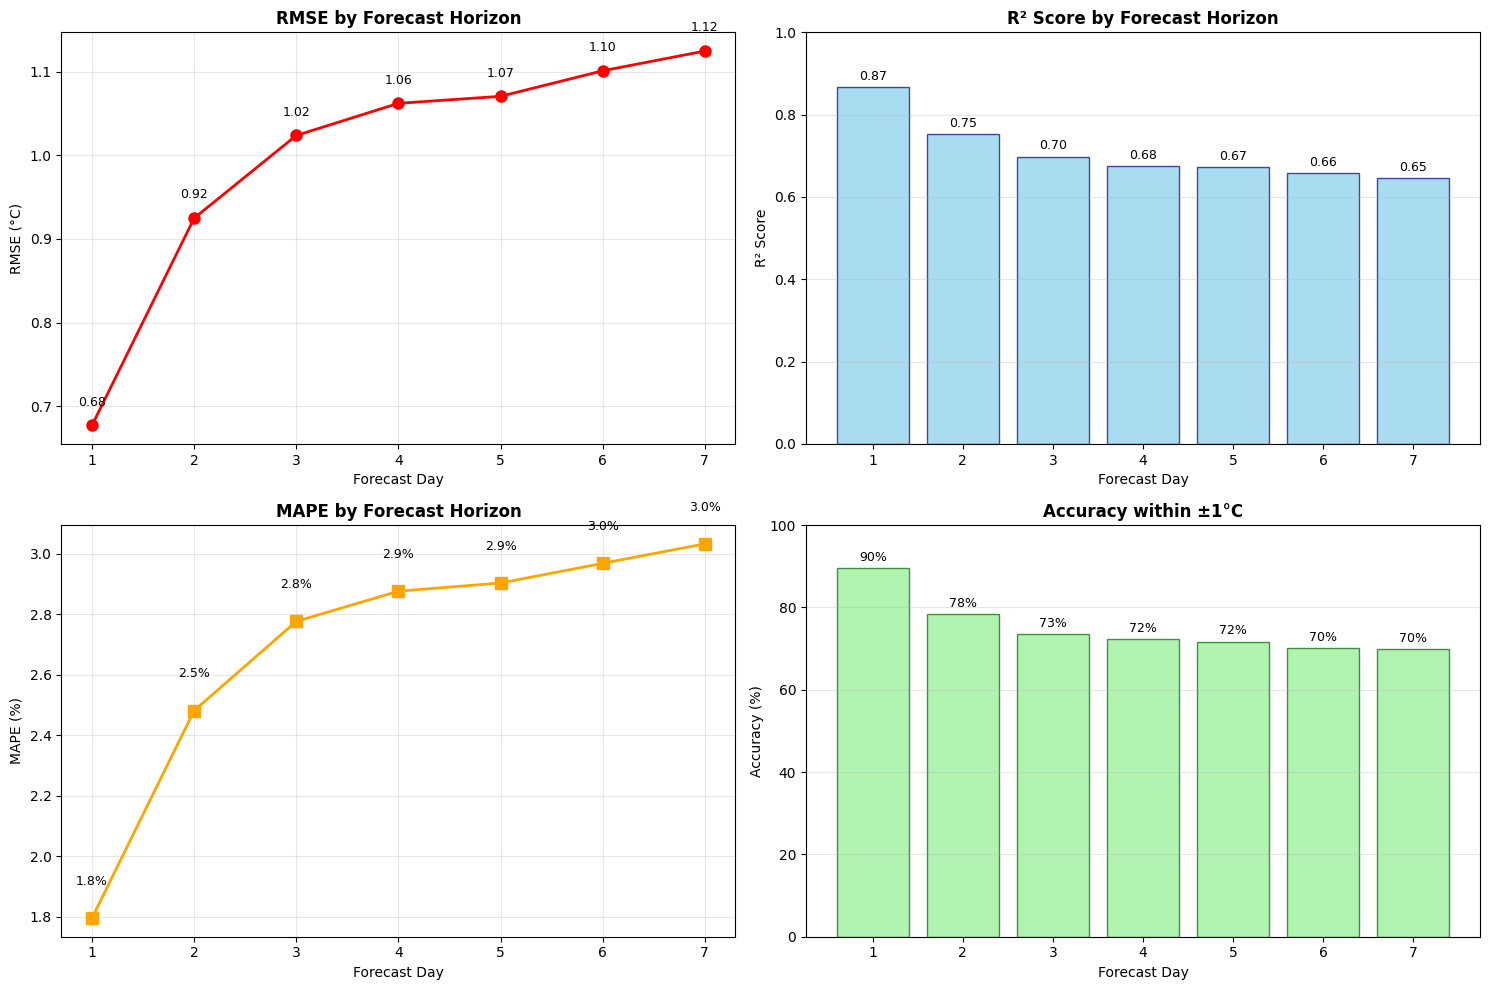

In [50]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = Y_test.iloc[:, h]
    y_pred_h = Y_pred[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_overall = mean_absolute_error(Y_test, Y_pred)
mape_overall = mape(Y_test, Y_pred)
r2_overall = r2_score(Y_test, Y_pred)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.677 | Day +2: 0.925 | Day +3: 1.024 | Day +4: 1.062 | Day +5: 1.070 | Day +6: 1.101 | Day +7: 1.125

==== MAE ====
Day +1: 0.503 | Day +2: 0.689 | Day +3: 0.771 | Day +4: 0.799 | Day +5: 0.806 | Day +6: 0.823 | Day +7: 0.841

==== MAPE (%) ====
Day +1: 1.80% | Day +2: 2.48% | Day +3: 2.78% | Day +4: 2.88% | Day +5: 2.90% | Day +6: 2.97% | Day +7: 3.03%

==== R² ====
Day +1: 0.867 | Day +2: 0.753 | Day +3: 0.698 | Day +4: 0.676 | Day +5: 0.673 | Day +6: 0.658 | Day +7: 0.647

==== Accuracy (%) from R² ====
Day +1: 86.7% | Day +2: 75.3% | Day +3: 69.8% | Day +4: 67.6% | Day +5: 67.3% | Day +6: 65.8% | Day +7: 64.7%

==== Overall ====
RMSE=1.008 | MAE=0.747 | MAPE=2.69% | R²=0.710 | Accuracy=71.0%


### Predict 7 days

In [52]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_lgbm.predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-14 (Friday)
Starting forecast from: 2025-11-15 (Saturday)

Day +1: 2025-11-15 (Saturday) → 25.43°C
Day +2: 2025-11-16 (Sunday) → 25.51°C
Day +3: 2025-11-17 (Monday) → 25.75°C
Day +4: 2025-11-18 (Tuesday) → 25.54°C
Day +5: 2025-11-19 (Wednesday) → 25.39°C
Day +6: 2025-11-20 (Thursday) → 25.52°C
Day +7: 2025-11-21 (Friday) → 25.62°C

Forecast Range: 25.39°C to 25.75°C
Average Temperature: 25.54°C
7-day Trend: increasing (0.19°C change)


### Pattern plot

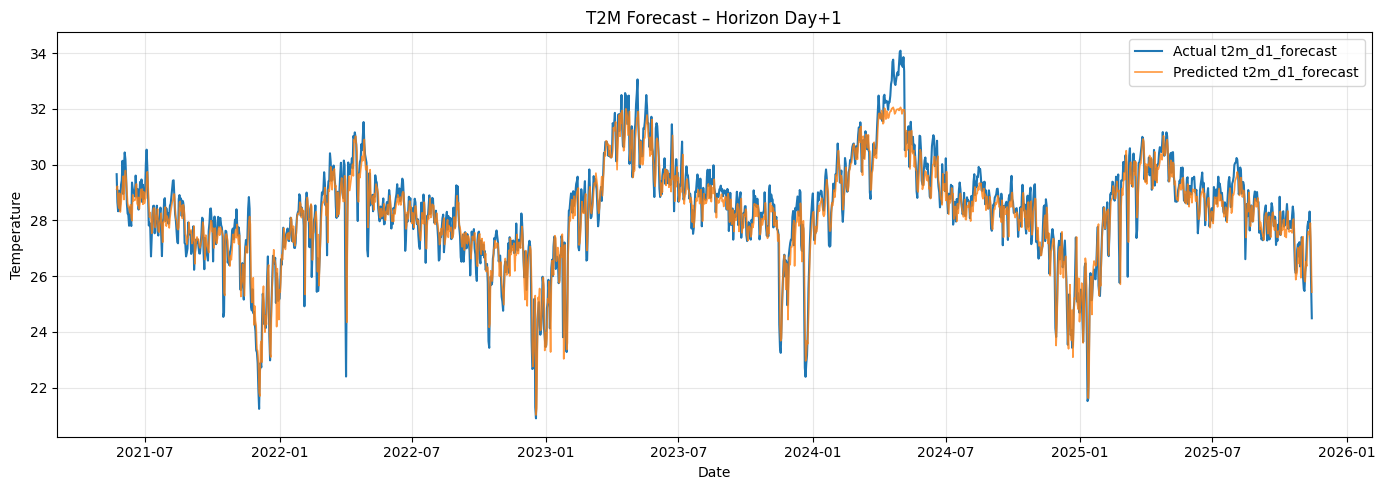

In [53]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

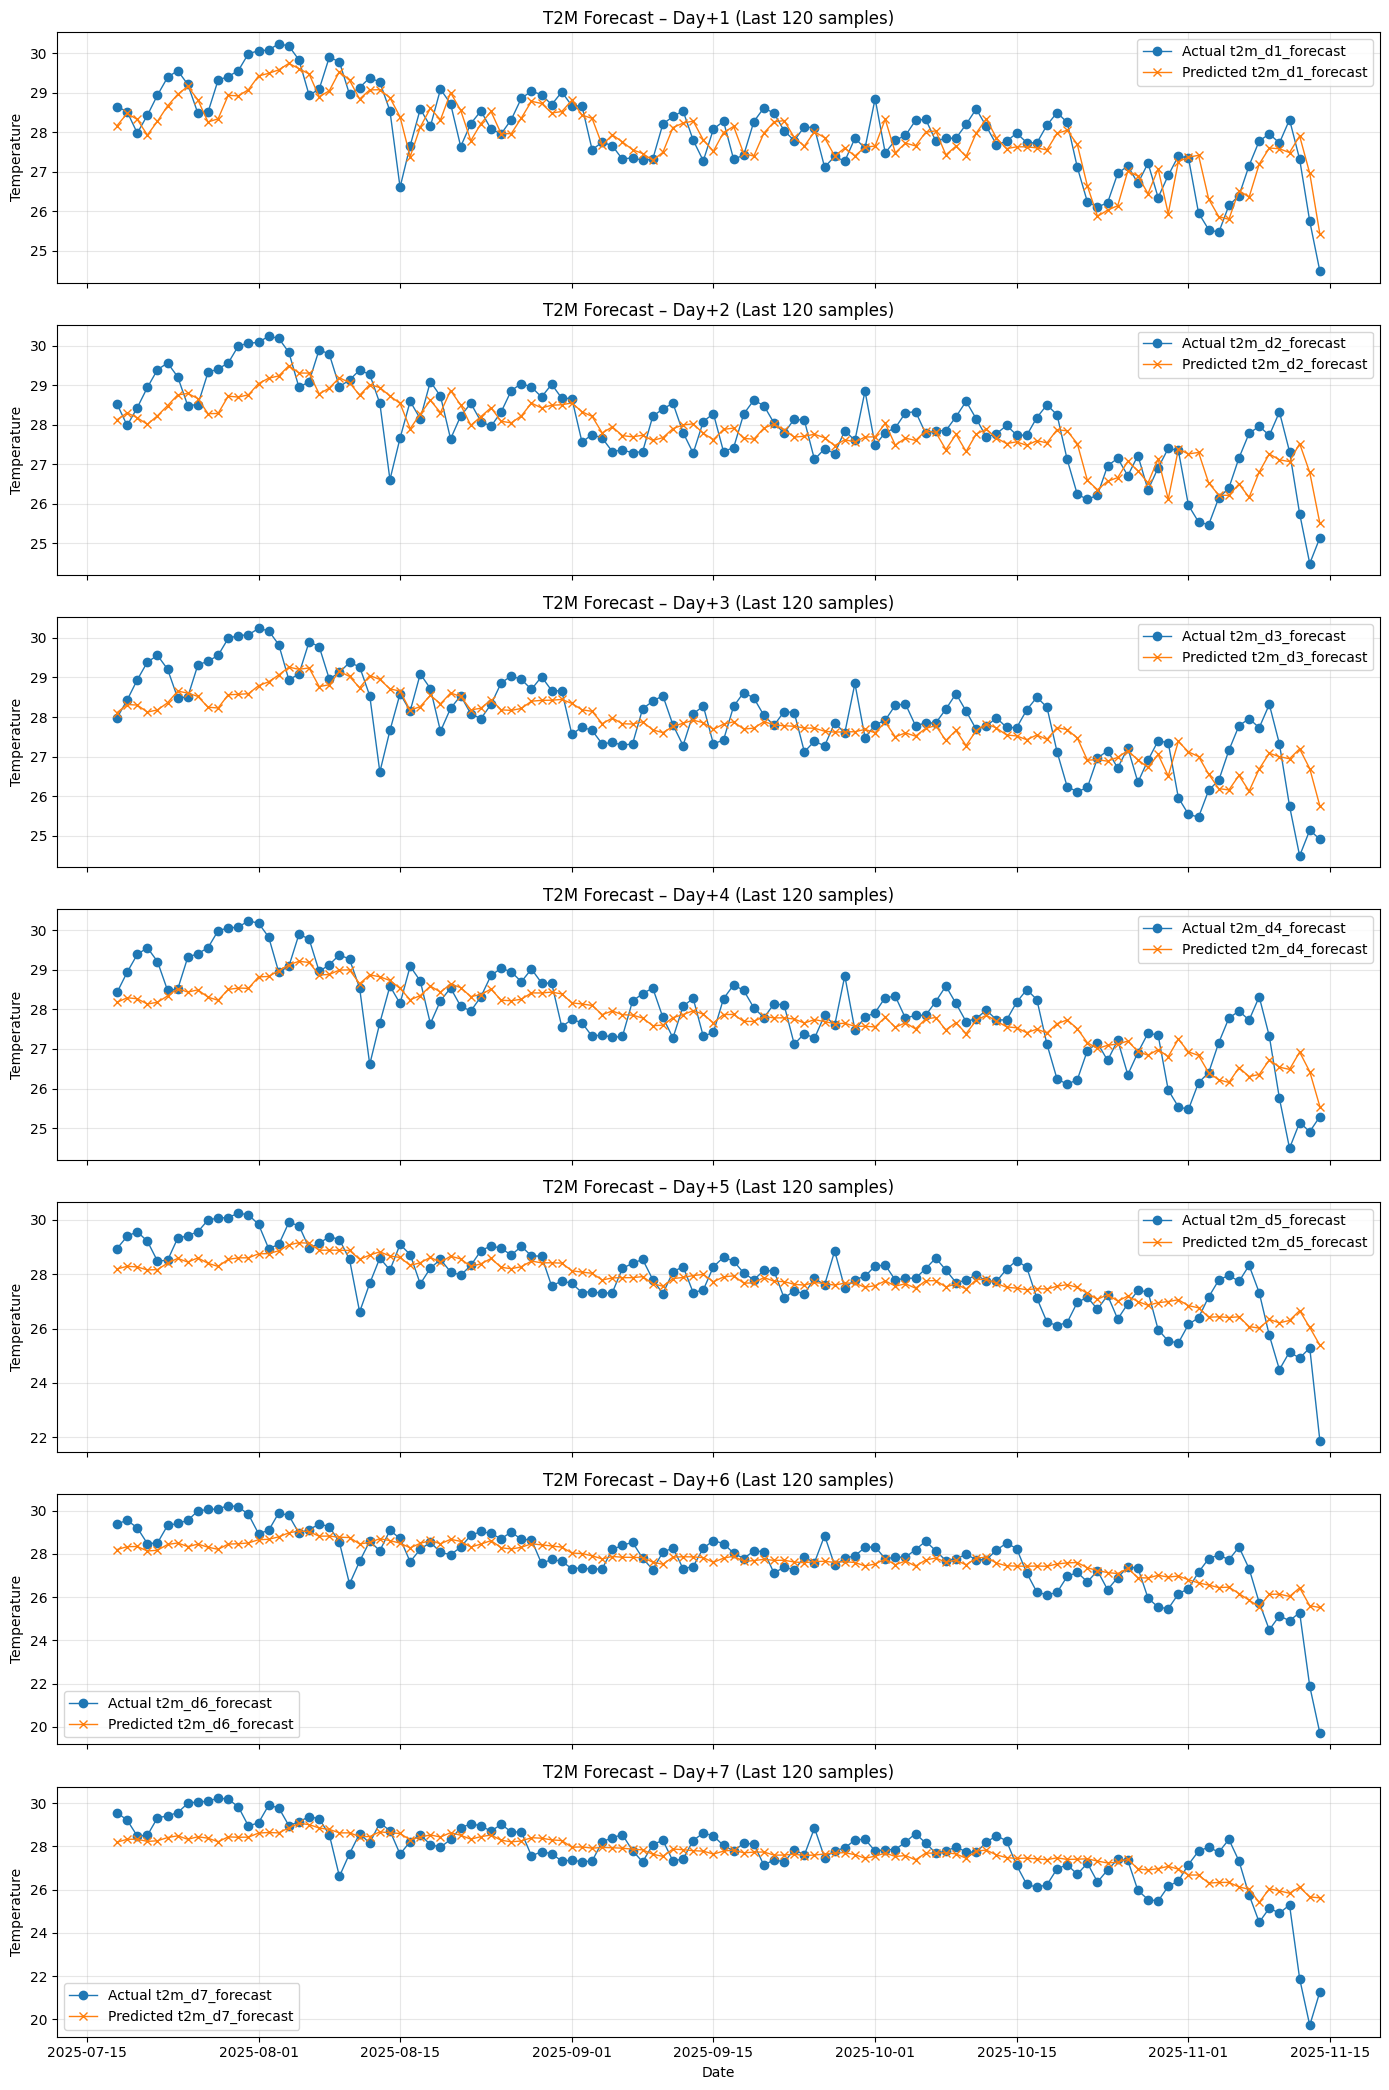

In [54]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Export Weight Model

In [56]:
import joblib

joblib.dump(model_lgbm, "../Model/Weight/LightGBM_Multi_T2M_Model.joblib")
print("Model exported to Model/Weight/LightGBM_Multi_T2M_Model.joblib")

Model exported to Model/Weight/LightGBM_Multi_T2M_Model.joblib
